In [1]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))
display(HTML("<style>.container {width:100% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: roicat


In [2]:
from pathlib import Path
import copy
import functools
import gc

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import natsort
import sklearn
import torch


In [3]:
%load_ext autoreload
%autoreload 2
import bnpm

In [4]:
mouse = 'mouse_0322N'

In [48]:
dir_dFoF = f'/media/rich/bigSSD/analysis_data/face_rhythm/{mouse}/dFoF_aligned/'

if mouse == 'mouse_0322R':
    ## mouse_0322R
    dates_toExclude = [
        '20230507',
        '20230515',
    ]

elif mouse == 'mouse_0403L':
    ## mouse_0403L
    dates_toExclude = [
        '20230719',
    ]

elif mouse == 'mouse_0322N':
    # 0322N
    dates_toExclude = []


else:
    dates_toExclude = []

In [49]:
dir_tca = f'/media/rich/bigSSD/analysis_data/face_rhythm/{mouse}/ws_and_tca__idx_SI/'

In [50]:
paths_dFoF = bnpm.path_helpers.find_paths(
    dir_outer=dir_dFoF,
    reMatch='dFoF_aligned.*npy',
    depth=4,
    natsorted=True,
)

In [51]:
paths_dFoF

['/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/dFoF_aligned/20230430/dFoF_aligned.npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/dFoF_aligned/20230501/dFoF_aligned.npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/dFoF_aligned/20230502/dFoF_aligned.npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/dFoF_aligned/20230503/dFoF_aligned.npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/dFoF_aligned/20230504/dFoF_aligned.npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/dFoF_aligned/20230505/dFoF_aligned.npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/dFoF_aligned/20230506/dFoF_aligned.npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/dFoF_aligned/20230507/dFoF_aligned.npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/dFoF_aligned/20230508/dFoF_aligned.npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/dFoF_aligned/20230509/dFoF_aligned.npy',


In [52]:
dates_dFoF = [Path(p).parts[-2] for p in paths_dFoF]

In [53]:
# display(dates)
# display(paths_dFoF)

In [54]:
dFoFs = {d: np.load(p, mmap_mode='r') for d, p in zip(dates_dFoF, paths_dFoF)}

In [55]:
for date in dates_toExclude:
    try:
        dFoFs.pop(date)
    except:
        print(f'failed to exclude date: {date}')

In [56]:
paths_tca = bnpm.path_helpers.find_paths(
    dir_outer=dir_tca,
    reMatch='tca.*npy',
    depth=4,
    natsorted=True,
    verbose=True,
)

dates_tca = [Path(p).parts[-2] for p in paths_tca]

/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/ws_and_tca__idx_SI/20230430/tca_idxSI.npy
/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/ws_and_tca__idx_SI/20230501/tca_idxSI.npy
/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/ws_and_tca__idx_SI/20230502/tca_idxSI.npy
/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/ws_and_tca__idx_SI/20230503/tca_idxSI.npy
/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/ws_and_tca__idx_SI/20230504/tca_idxSI.npy
/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/ws_and_tca__idx_SI/20230505/tca_idxSI.npy
/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/ws_and_tca__idx_SI/20230506/tca_idxSI.npy
/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/ws_and_tca__idx_SI/20230507/tca_idxSI.npy
/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/ws_and_tca__idx_SI/20230508/tca_idxSI.npy
/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/ws_and_tca__idx_SI/20230509/tca_idxSI.npy
/media/ric

In [57]:
tcas = {d: np.load(p, mmap_mode='r') for d, p in zip(dates_tca, paths_tca)}

In [58]:
def prep_array_for_regression(arr, mean_sub=False, std_div=False, device='cpu'):
    out = torch.as_tensor(arr, dtype=torch.float32, device=device)
    if mean_sub:
        out = out - torch.nanmean(out, dim=1, keepdim=True)
    out = torch.nan_to_num(out, nan=0.0)
    if std_div:
        out = out / out.std(1, keepdim=True)
    return out

In [59]:
DEVICE_regression = bnpm.torch_helpers.set_device(use_GPU=True)

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)


In [60]:
automodel_partial = functools.partial(
    bnpm.automatic_regression.Auto_RidgeRegression,
    params_RidgeRegression={
#         'alpha': [1e-1, 1e6],
        'alpha': 10**3.5,
        'fit_intercept': False,
#         'max_iter': 1000,
#         'tol': 0.0001,
#         'solver': 'cholesky',
#         'positive': False,
    },
    n_startup=36*1,
    kwargs_convergence={
        'n_patience': 36*1,
        'tol_frac': 0.01,
#         'max_trials': 100,
        'max_trials': 1,
        'max_duration': 60*10,
    }, 
#     n_repeats=100,
    n_repeats=1,
    fn_reduce_repeats=torch.median,
    n_jobs_optuna=1,
    penalty_testTrainRatio=1e0,
    test_size=0.3,
    verbose=False,
    use_rich_method=True,
)

In [61]:
DEVICE_regression = bnpm.torch_helpers.set_device(use_GPU=True)

n_splits = 100
test_size = 0.3

# automodels = {}
models = {}
alphas = {}
evrs_date = {}
for date in tqdm(tcas.keys()):
    if date not in dFoFs:
        continue
        
    dfof = prep_array_for_regression(dFoFs[date], mean_sub=True, std_div=False, device=DEVICE_regression)
    tca  = prep_array_for_regression(tcas[date], mean_sub=True, std_div=True, device=DEVICE_regression)

    cv = sklearn.model_selection.GroupShuffleSplit(n_splits=1, test_size=test_size)
    cv.split = functools.partial(cv.split, groups=bnpm.cross_validation.make_groups(n_samples=dfof.T.shape[0], group_size=30*60*2))
    
    alphas[date] = []
#     automodels[date] = []
    models[date] = []
    for i_tca, t in enumerate(tca.T):
        automodel = automodel_partial(
            X=dfof.T,
            y=t[:,None],
            cv=cv,
        )
        automodel.fit()
#         automodel.plot_param_curve('alpha')
        
#         automodels[date].append(copy.deepcopy(automodel.numpy()))
        models[date].append(automodel.model_best.numpy())
    
        alphas[date].append(automodel.model_best.alpha)
        
    evrs_tca = []
    for i_tca, t in enumerate(tca.T):
        model = bnpm.linear_regression.Ridge(alpha=alphas[date][i_tca], fit_intercept=False)
        evrs_splits = []
        for i_split in range(n_splits):
            idx_train, idx_test = next(cv.split(np.arange(dfof.T.shape[0])))
            model.fit(
                X=dfof.T[idx_train, :], 
                y=t[idx_train, None],
            )
            y_rec = model.predict(X=dfof.T[idx_test, :])
            v1_orth, EVR, _, _ = bnpm.similarity.orthogonalize(
                v1=t[idx_test, None],
                v2=y_rec,
                method='OLS',
                device=DEVICE_regression,
            )
#             evr_tmp = model.score(
#                 X=dfof.T[idx_test, :],
#                 y=t[idx_test, None],
#             )
            evrs_splits.append(EVR[0].cpu().numpy())
        evrs_tca.append(np.stack(evrs_splits))
    evrs_date[date] = np.stack(evrs_tca, axis=0)
    

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)


100%|███████████████████████████████████████████| 31/31 [09:49<00:00, 19.02s/it]


cross-model

In [62]:
def dict_to_numpy(d):
    out = {}
    for key, val in d.items():
        if isinstance(val, dict):
            out[key] = dict_to_numpy(val)
        elif isinstance(val, torch.Tensor):
            out[key] = val.cpu().numpy()
        elif isinstance(val, np.ndarray):
            out[key] = val
        else:
            out[key] = val

    return out

In [63]:
crossmodel_outs = np.zeros((len(models), len(models)), dtype=object)
for ii, date_i in tqdm(enumerate(list(models.keys()))):
    dfof_i = prep_array_for_regression(dFoFs[date_i], mean_sub=True, std_div=False, device=DEVICE_regression)
    tca_i  = prep_array_for_regression(tcas[date_i], mean_sub=True, std_div=True, device=DEVICE_regression)
    
    for jj, date_j in enumerate(models.keys()):
        thetas = np.concatenate([m.numpy().coef_ for m in models[date_j]], axis=1)
        biases = np.concatenate([m.numpy().intercept_ for m in models[date_j]])
        y_rec = np.concatenate([m.to(DEVICE_regression).predict(X=dfof_i.T).cpu().numpy() for m in models[date_j]], axis=1)
    
        v1_orth, EVR, EVR_total_weighted, EVR_total_unweighted = bnpm.similarity.pairwise_orthogonalization_torch(
            v1=tca_i,
            v2=y_rec,
            center=True,
            device=DEVICE_regression,
        )
    
        crossmodel_outs[ii, jj] = {}
        crossmodel_outs[ii, jj]['thetas'] = thetas
#         crossmodel_outs[ii, jj]['y_recs'] = y_rec
        crossmodel_outs[ii, jj]['biases'] = biases
        crossmodel_outs[ii, jj]['orthogonalization'] = {
#             'v1_orth': v1_orth, 
            'EVR': EVR, 
            'EVR_total_weighted': EVR_total_weighted, 
            'EVR_total_unweighted': EVR_total_unweighted, 
        }
        crossmodel_outs[ii, jj] = dict_to_numpy(crossmodel_outs[ii, jj])

[[m.numpy() for m in ms] for ms in models.values()];

30it [00:09,  3.03it/s]


In [64]:
rank = crossmodel_outs[0,0]['thetas'].shape[1]

In [65]:
EVRs = np.zeros(tuple(crossmodel_outs.shape) + (rank,), dtype=np.float32)
for ii in range(EVRs.shape[0]):
    for jj in range(EVRs.shape[1]):
        EVRs[ii,jj] = crossmodel_outs[ii,jj]['orthogonalization']['EVR']
        # test2[ii,jj] = crossmodel_outs[ii,jj]['orthogonalization']['EVR'][3]

In [66]:
EVRs[range(EVRs.shape[0]), range(EVRs.shape[1]), :] = np.array([e.mean(1) for e in evrs_date.values()])

In [67]:
make_symmetric = lambda x: (x + x.transpose(1,0,2))/2

EVRs_symm = make_symmetric(EVRs)

In [68]:
%matplotlib inline
figsaver = bnpm.plotting_helpers.Figure_Saver(
    dir_save=f'/media/rich/bigSSD/analysis_data/face_rhythm/{mouse}/drift/ims',
    format_save=['png'],
    overwrite=True,
)

RH Warning: Overwriting file. File: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/drift/ims/EVRs_raw.png already exists.


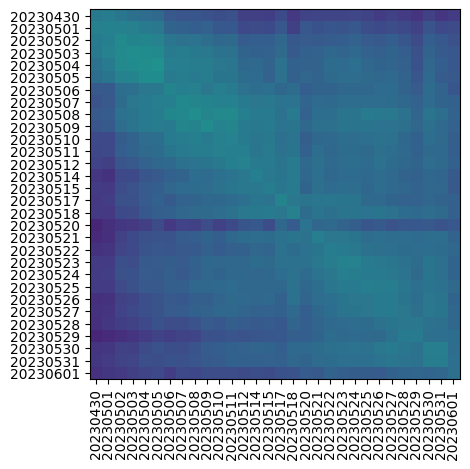

In [69]:
fig = plt.figure()
plt.imshow(EVRs.mean(2), clim=[0,1])
plt.xticks(np.arange(EVRs.shape[0]), labels=models.keys(), rotation=90);
plt.yticks(np.arange(EVRs.shape[0]), labels=models.keys(), rotation=0);
figsaver(fig, name_file='EVRs_raw')


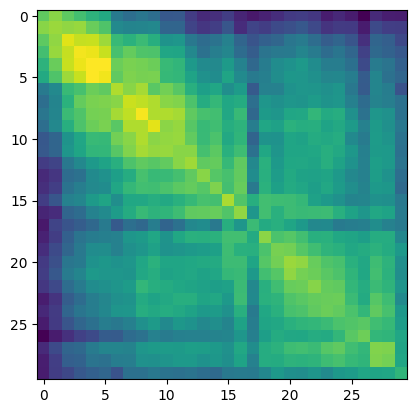

In [70]:
plt.figure()
plt.imshow(EVRs_symm.mean(2))

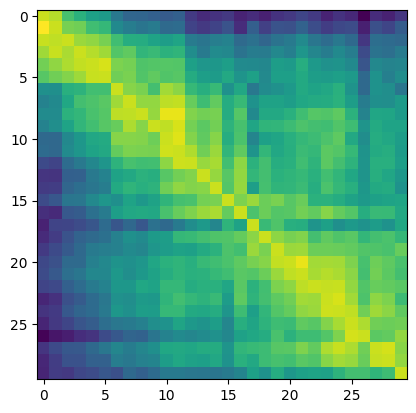

In [71]:
plt.figure()
plt.imshow(EVRs_symm.mean(2) / EVRs_symm.mean(2).diagonal(offset=0)[None,:])

In [72]:
EVRs_norm = EVRs_symm / EVRs_symm.diagonal(offset=0).T[:,None]

In [73]:
EVRs_norm[range(EVRs_norm.shape[0]), range(EVRs_norm.shape[0]), :] = 0

RH Warning: Overwriting file. File: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/drift/ims/EVRs_norm.png already exists.


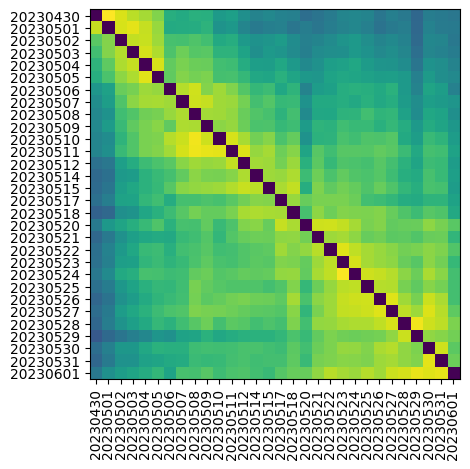

In [74]:
%matplotlib inline
fig = plt.figure()
plt.imshow(EVRs_norm.mean(2))
plt.xticks(np.arange(EVRs_norm.shape[0]), labels=models.keys(), rotation=90);
plt.yticks(np.arange(EVRs_norm.shape[0]), labels=models.keys(), rotation=0);
figsaver(fig, name_file='EVRs_norm')

RH Warning: Overwriting file. File: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/drift/ims/factors/factor_0.png already exists.
RH Warning: Overwriting file. File: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/drift/ims/factors/factor_1.png already exists.
RH Warning: Overwriting file. File: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/drift/ims/factors/factor_2.png already exists.
RH Warning: Overwriting file. File: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/drift/ims/factors/factor_3.png already exists.
RH Warning: Overwriting file. File: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/drift/ims/factors/factor_4.png already exists.
RH Warning: Overwriting file. File: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/drift/ims/factors/factor_5.png already exists.
RH Warning: Overwriting file. File: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/drift/ims/factors/factor_6.png already exists.
RH Warning: Overwrit

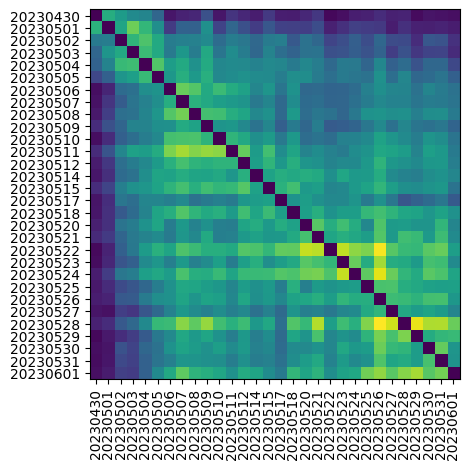

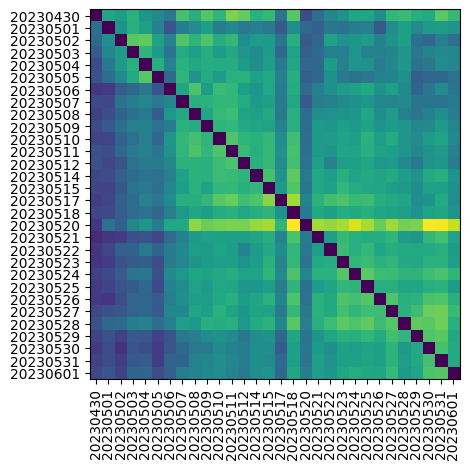

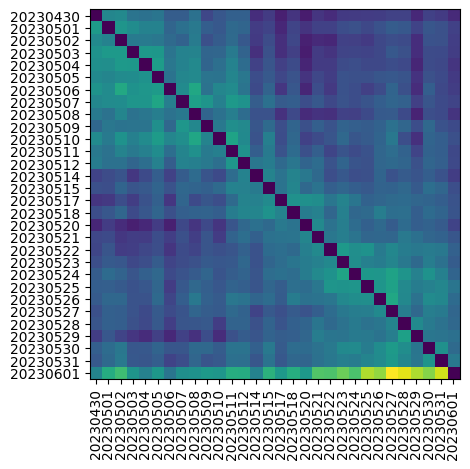

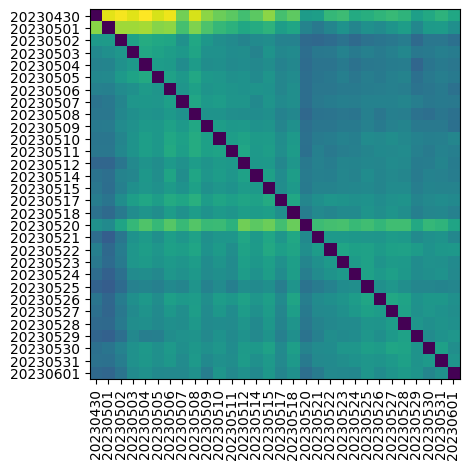

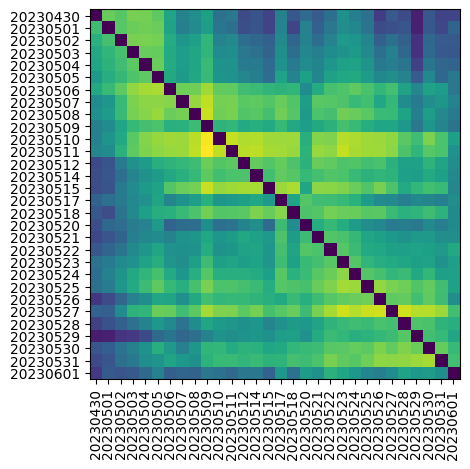

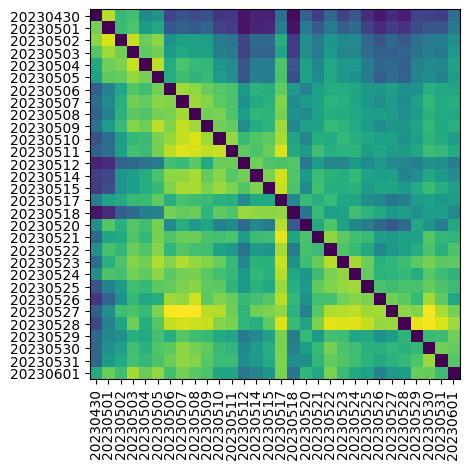

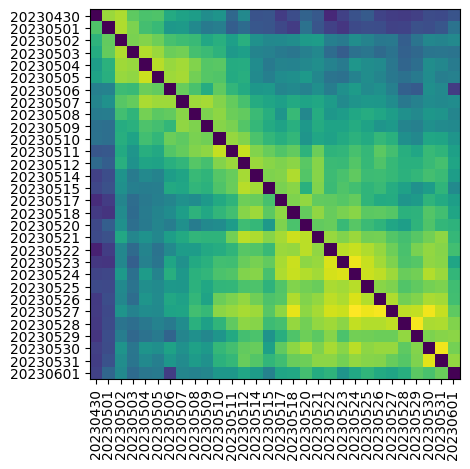

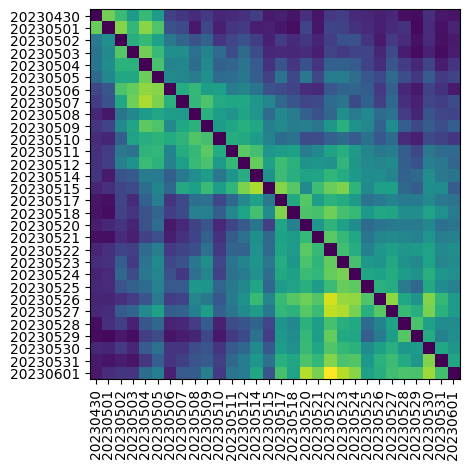

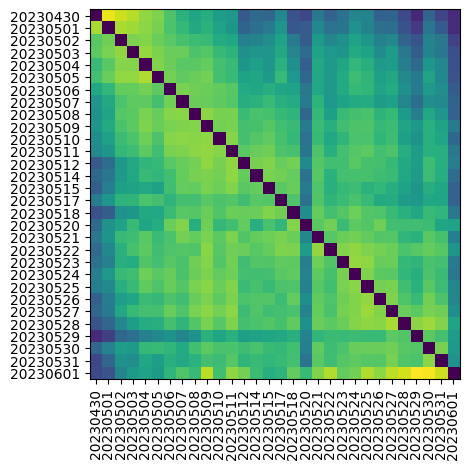

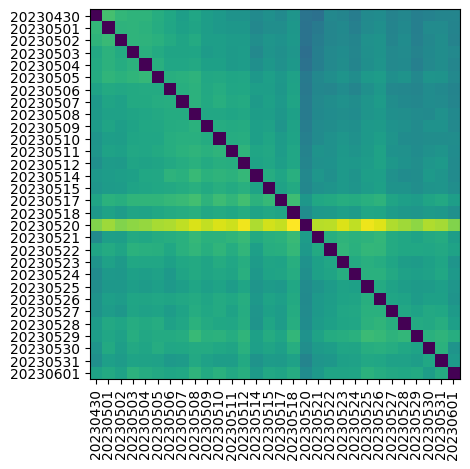

In [75]:
%matplotlib inline

for ii in range(EVRs_norm.shape[2]):
    fig = plt.figure()
    plt.imshow(EVRs_norm[:,:,ii])
    plt.xticks(np.arange(EVRs_norm.shape[0]), labels=models.keys(), rotation=90);
    plt.yticks(np.arange(EVRs_norm.shape[0]), labels=models.keys(), rotation=0);
    figsaver(fig, name_file=f'factors/factor_{ii}')

In [76]:
normalizer_2d = np.logical_not(np.eye(EVRs_norm.shape[0]))

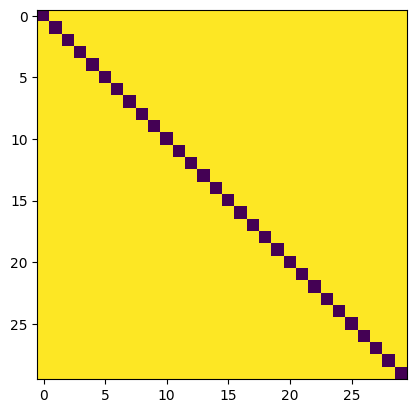

In [77]:
plt.figure()
plt.imshow(normalizer_2d)

In [78]:
import scipy.signal

In [79]:
gaus_2d = bnpm.featurization.gaussian_kernel_2D(
    image_size=(11,11),
    sig=1.5,
)
gaus_2d = gaus_2d / gaus_2d.sum()
    

In [80]:
EVRs_norm_conv = np.stack([scipy.signal.convolve2d(e, gaus_2d, mode='same', boundary='symm') for e in EVRs_norm.transpose(2,0,1)], axis=-1)

In [81]:
normalizer_conv = scipy.signal.convolve2d(normalizer_2d, gaus_2d, mode='same', boundary='symm')

In [82]:
normalizer_conv.shape

(30, 30)

In [83]:
EVRs_norm_conv_normd = EVRs_norm_conv / normalizer_conv[:,:,None]

RH Warning: Overwriting file. File: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/drift/ims/EVRs_conv.png already exists.


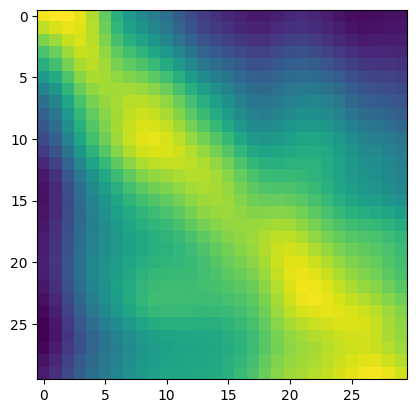

In [84]:
fig = plt.figure()
plt.imshow(EVRs_norm_conv_normd.mean(2), clim=[None,None])
figsaver(fig, name_file='EVRs_conv')

In [85]:
results = {
    'dir_dFoF': dir_dFoF,
    'dir_tca': dir_tca,
    'cv_test_size': cv.test_size,
    'automodel_params_RidgeRegression': automodel_partial.keywords['params_RidgeRegression'],
    'cv_n_splits': n_splits,
    'device': DEVICE_regression,
    'models': {key: [m.__dict__ for m in md] for key, md in models.items()},
    'evrs_date': evrs_date,
    'crossmodel_outs': crossmodel_outs,
    'rank': rank,
    'EVRs': EVRs,
    'EVRs_norm': EVRs_norm,
    'EVRs_norm_conv_normd': EVRs_norm_conv_normd,
}

In [86]:
bnpm.file_helpers.pickle_save(
    obj=results,
    filepath=f'/media/rich/bigSSD/analysis_data/face_rhythm/{mouse}/drift/decoding_drift.pkl',
    mode='wb',
    mkdir=True,
)